Epoch 1/5
1929/1929 - 6s - loss: 0.0365 - val_loss: 0.0032 - 6s/epoch - 3ms/step
Epoch 2/5
1929/1929 - 5s - loss: 0.0038 - val_loss: 0.0034 - 5s/epoch - 2ms/step
Epoch 3/5
1929/1929 - 4s - loss: 0.0038 - val_loss: 0.0039 - 4s/epoch - 2ms/step
Epoch 4/5
1929/1929 - 4s - loss: 0.0038 - val_loss: 0.0031 - 4s/epoch - 2ms/step
Epoch 5/5
1929/1929 - 4s - loss: 0.0037 - val_loss: 0.0033 - 4s/epoch - 2ms/step
1/1 [==============================] - 0s 22ms/step
                       Time  Predicted Humidity
0 2016-12-31 23:00:00+00:00            0.825935
1 2017-01-01 00:00:00+00:00            1.003393
2 2017-01-01 01:00:00+00:00            0.970521
3 2017-01-01 02:00:00+00:00            1.130113
4 2017-01-01 03:00:00+00:00            1.126568


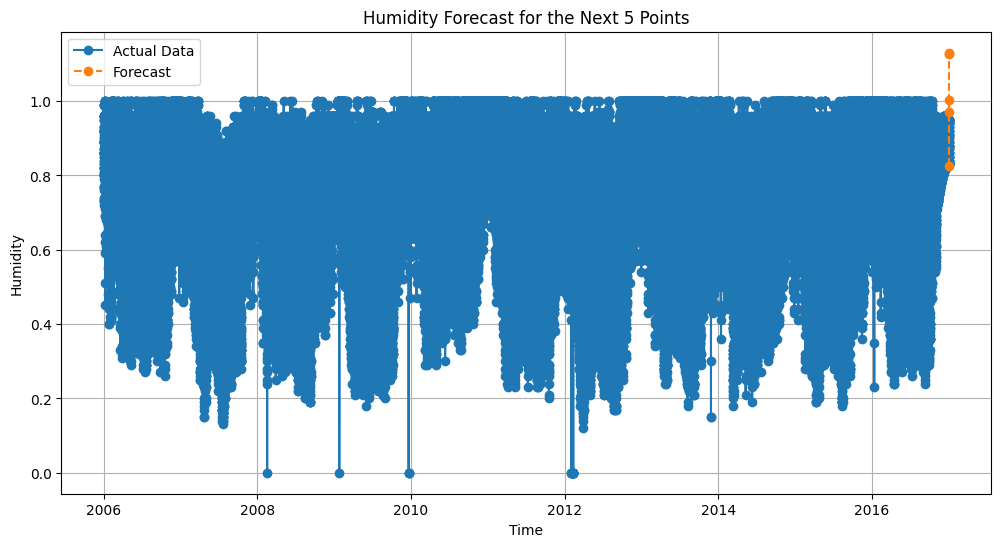

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

# Load the dataset
df = pd.read_csv('D:/New folder/data_prepration/humidity_data.csv')

# Convert the 'Formatted Date' column to datetime format
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)

# Sort the DataFrame based on the 'Formatted Date' column
df = df.sort_values('Formatted Date')

# Create a time-based feature (e.g., hour of the day)
df['Hour'] = df['Formatted Date'].dt.hour

# Select relevant columns for modeling
data = df[['Formatted Date', 'Humidity', 'Hour']]

# Normalize the humidity values
scaler = MinMaxScaler()
data[['Humidity']] = scaler.fit_transform(data[['Humidity']])

# Create sequences for time series forecasting
sequence_length = 24  # Using 24 hours as one sequence
X, y = [], []

for i in range(len(data) - sequence_length):
    seq = data.iloc[i:i + sequence_length]
    X.append(seq[['Humidity', 'Hour']].values)
    y.append(data.iloc[i + sequence_length]['Humidity'])

X, y = np.array(X), np.array(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the RNN model
model = keras.Sequential([
    layers.SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=2)

# Get user input for the number of points to predict
num_points_to_predict = int(input("Enter the number of points to predict: "))

# Initialize an array for predictions
forecasted_humidity = []

# Create the initial input sequence for forecasting
last_sequence = X_test[-1]

# Generate forecasts for the specified number of points
for _ in range(num_points_to_predict):
    # Predict the next humidity
    next_humidity = model.predict(last_sequence.reshape(1, sequence_length, 2))[0][0]

    # Update the sequence with the predicted humidity and the current hour
    last_sequence = np.vstack([last_sequence[1:], np.array([next_humidity, df['Hour'].iloc[-num_points_to_predict + _]])])

    # Store the predicted humidity
    forecasted_humidity.append(next_humidity)

# Denormalize the forecasted humidity
forecasted_humidity = scaler.inverse_transform(np.array(forecasted_humidity).reshape(-1, 1))

# Generate time points for the forecast
forecast_time_points = pd.date_range(df['Formatted Date'].max(), periods=num_points_to_predict + 1, freq='H')[1:]

# Create a DataFrame for the predicted values
predicted_df = pd.DataFrame({'Time': forecast_time_points, 'Predicted Humidity': forecasted_humidity.flatten()})

# Print the predicted values
print(predicted_df)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(df['Formatted Date'], df['Humidity'], label='Actual Data', linestyle='-', marker='o')
plt.plot(predicted_df['Time'], predicted_df['Predicted Humidity'], label='Forecast', linestyle='--', marker='o')
plt.title(f'Humidity Forecast for the Next {num_points_to_predict} Points')
plt.xlabel('Time')
plt.ylabel('Humidity')
plt.legend()
plt.grid(True)
plt.show()


In [2]:
import joblib
# Save the model
model.save('D:/RNN_based_airfield/models/Humidity_model.h5')
# Save the scaler
joblib.dump({'min_': scaler.min_, 'scale_': scaler.scale_}, 'D:/RNN_based_airfield/models/Humidity_Scaler.joblib')

['D:/RNN_based_airfield/models/Humidity_Scaler.joblib']

Epoch 1/5
1929/1929 - 6s - loss: 0.0241 - val_loss: 0.0079 - 6s/epoch - 3ms/step
Epoch 2/5
1929/1929 - 6s - loss: 0.0050 - val_loss: 0.0043 - 6s/epoch - 3ms/step
Epoch 3/5
1929/1929 - 5s - loss: 0.0043 - val_loss: 0.0038 - 5s/epoch - 2ms/step
Epoch 4/5
1929/1929 - 5s - loss: 0.0042 - val_loss: 0.0061 - 5s/epoch - 2ms/step
Epoch 5/5
1929/1929 - 5s - loss: 0.0038 - val_loss: 0.0051 - 5s/epoch - 3ms/step
1/1 [==============================] - 0s 19ms/step
                       Time  Predicted Humidity
0 2016-12-31 23:00:00+00:00            0.769287
1 2017-01-01 00:00:00+00:00            0.293173
2 2017-01-01 01:00:00+00:00            0.320509
3 2017-01-01 02:00:00+00:00            0.584633
4 2017-01-01 03:00:00+00:00            0.709227
5 2017-01-01 04:00:00+00:00            0.570255


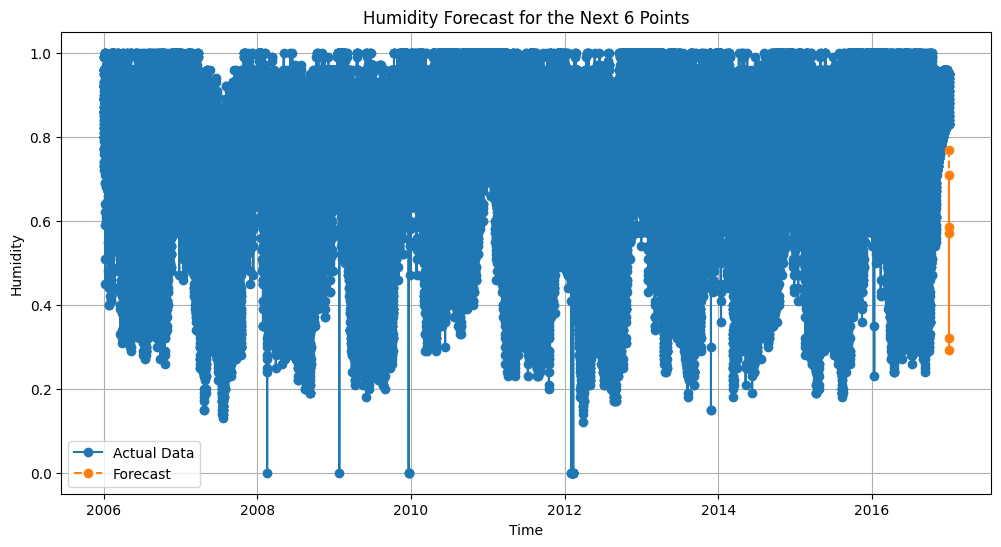

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

# Load the dataset
df = pd.read_csv('D:/New folder/data_prepration/humidity_data.csv')

# Convert the 'Formatted Date' column to datetime format
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)

# Sort the DataFrame based on the 'Formatted Date' column
df = df.sort_values('Formatted Date')

# Create a time-based feature (e.g., hour of the day)
df['Hour'] = df['Formatted Date'].dt.hour

# Select relevant columns for modeling
data = df[['Formatted Date', 'Humidity', 'Hour']]

# Create sequences for time series forecasting
sequence_length = 24  # Using 24 hours as one sequence
X, y = [], []

for i in range(len(data) - sequence_length):
    seq = data.iloc[i:i + sequence_length]
    X.append(seq[['Humidity', 'Hour']].values)
    y.append(data.iloc[i + sequence_length]['Humidity'])

X, y = np.array(X), np.array(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the RNN model
model = keras.Sequential([
    layers.SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=2)

# Save the trained model
model.save('D:/AF_scratch/nonscaledmodel/Humidity_model.h5')

# Get user input for the number of points to predict
num_points_to_predict = int(input("Enter the number of points to predict: "))

# Initialize an array for predictions
forecasted_humidity = []

# Create the initial input sequence for forecasting
last_sequence = X_test[-1]

# Generate forecasts for the specified number of points
for _ in range(num_points_to_predict):
    # Predict the next humidity
    next_humidity = model.predict(last_sequence.reshape(1, sequence_length, 2))[0][0]

    # Update the sequence with the predicted humidity and the current hour
    last_sequence = np.vstack([last_sequence[1:], np.array([next_humidity, df['Hour'].iloc[-num_points_to_predict + _]])])

    # Store the predicted humidity
    forecasted_humidity.append(next_humidity)

# Generate time points for the forecast
forecast_time_points = pd.date_range(df['Formatted Date'].max(), periods=num_points_to_predict + 1, freq='H')[1:]

# Create a DataFrame for the predicted values
predicted_df = pd.DataFrame({'Time': forecast_time_points, 'Predicted Humidity': forecasted_humidity})

# Print the predicted values
print(predicted_df)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(df['Formatted Date'], df['Humidity'], label='Actual Data', linestyle='-', marker='o')
plt.plot(predicted_df['Time'], predicted_df['Predicted Humidity'], label='Forecast', linestyle='--', marker='o')
plt.title(f'Humidity Forecast for the Next {num_points_to_predict} Points')
plt.xlabel('Time')
plt.ylabel('Humidity')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

# Load the dataset
df = pd.read_csv('D:/AF_scratch/code/data.csv')

# Convert the 'Formatted Date' column to datetime format
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)

# Sort the DataFrame based on the 'Formatted Date' column
df = df.sort_values('Formatted Date')

# Create a time-based feature (e.g., hour of the day)
df['Hour'] = df['Formatted Date'].dt.hour

# Select relevant columns for modeling
data = df[['Formatted Date', 'Humidity', 'Hour']]

# Create sequences for time series forecasting
sequence_length = 24  # Using 24 hours as one sequence
X, y = [], []

for i in range(len(data) - sequence_length):
    seq = data.iloc[i:i + sequence_length]
    X.append(seq[['Humidity', 'Hour']].values)
    y.append(data.iloc[i + sequence_length]['Humidity'])

X, y = np.array(X), np.array(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the pre-trained model
loaded_model = keras.models.load_model('D:/AF_scratch/trained_model/Humidity_model.h5')

# Get the last 24 points from the test set to use as input for prediction
input_sequence = X_test[-1:]

# Predict the next 6 points
num_points_to_predict = 6
forecasted_humidity = []

for _ in range(num_points_to_predict):
    # Predict the next humidity
    next_humidity = loaded_model.predict(input_sequence)[0][0]

    # Update the input sequence with the predicted humidity and the current hour
    new_input_point = np.array([[next_humidity, df['Hour'].iloc[-num_points_to_predict + _]]])
    input_sequence = np.concatenate([input_sequence[:, 1:, :], new_input_point.reshape(1, 1, 2)], axis=1)

    # Store the predicted humidity
    forecasted_humidity.append(next_humidity)

# Generate time points for the forecast
forecast_time_points = pd.date_range(df['Formatted Date'].max(), periods=num_points_to_predict + 1, freq='H')[1:]

# Create a DataFrame for the predicted values
predicted_df = pd.DataFrame({'Time': forecast_time_points, 'Predicted Humidity': forecasted_humidity})

# Print the predicted values
print(predicted_df)





1/1 [==============================] - 0s 16ms/step
                       Time  Predicted Humidity
0 2023-01-10 01:00:00+00:00           57.577274
1 2023-01-10 02:00:00+00:00           50.631458
2 2023-01-10 03:00:00+00:00           44.493690
3 2023-01-10 04:00:00+00:00           38.011311
4 2023-01-10 05:00:00+00:00           31.665520
5 2023-01-10 06:00:00+00:00           25.320284


In [ ]:
# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(df['Formatted Date'], df['Humidity'], label='Actual Data', linestyle='-', marker='o')
plt.plot(predicted_df['Time'], predicted_df['Predicted Humidity'], label='Forecast', linestyle='--', marker='o')
plt.title(f'Humidity Forecast for the Next {num_points_to_predict} Points')
plt.xlabel('Time')
plt.ylabel('Humidity')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# import pandas as pd
# import numpy as np
# from datetime import timedelta

# # Function to generate synthetic time series data
# def generate_dummy_data(start_date, end_date, frequency='H'):
#     date_rng = pd.date_range(start=start_date, end=end_date, freq=frequency)
#     num_points = len(date_rng)

#     # Generate random humidity values
#     humidity_values = np.random.uniform(low=30, high=90, size=num_points)

#     # Create a DataFrame
#     dummy_data = pd.DataFrame({'Formatted Date': date_rng, 'Humidity': humidity_values})

#     # Convert the 'Formatted Date' column to datetime format
#     dummy_data['Formatted Date'] = pd.to_datetime(dummy_data['Formatted Date'], utc=True)

#     # Create a time-based feature (e.g., hour of the day)
#     dummy_data['Hour'] = dummy_data['Formatted Date'].dt.hour

#     return dummy_data

# # Set the start and end date for the dummy dataset
# start_date = '2023-01-01'
# end_date = '2023-01-10'

# # Generate dummy dataset
# dummy_dataset = generate_dummy_data(start_date, end_date)

# # Save the dummy dataset to a CSV file
# dummy_dataset.to_csv('data.csv', index=False)

# # Display the first few rows of the dummy dataset
# print(dummy_dataset)


               Formatted Date   Humidity  Hour
0   2023-01-01 00:00:00+00:00  30.703866     0
1   2023-01-01 01:00:00+00:00  61.188897     1
2   2023-01-01 02:00:00+00:00  88.773362     2
3   2023-01-01 03:00:00+00:00  87.466718     3
4   2023-01-01 04:00:00+00:00  59.653075     4
..                        ...        ...   ...
212 2023-01-09 20:00:00+00:00  41.278523    20
213 2023-01-09 21:00:00+00:00  40.578843    21
214 2023-01-09 22:00:00+00:00  45.614619    22
215 2023-01-09 23:00:00+00:00  56.749295    23
216 2023-01-10 00:00:00+00:00  72.671164     0

[217 rows x 3 columns]
